This project uses machine learning technique in detecting anomalies in of Energy Consumption to Infer Household Characteristics Using Smart Meters. Predictive models are defined which can help distribution systems to detect anomalies in household energy consumption to ensure power is delivered and also ensure safety of transmission lines.

Curator: Enoch Nuamah Appiah, MSc
contact: enoch.appiah@external.engie.com

In [ ]:
!pip install dataprep

     |████████████████████████████████| 163kB 22.0MB/s 
     |████████████████████████████████| 727kB 39.5MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 14.5MB 248kB/s 
     |████████████████████████████████| 9.2MB 44.8MB/s 
     |████████████████████████████████| 368kB 45.3MB/s 
     |████████████████████████████████| 10.1MB 173kB/s 
     |████████████████████████████████| 2.2MB 49.9MB/s 
     |████████████████████████████████| 8.6MB 42.1MB/s 
     |████████████████████████████████| 1.4MB 42.8MB/s 
     |████████████████████████████████| 1.2MB 48.5MB/s 
     |████████████████████████████████| 25.9MB 109kB/s 
     |████████████████████████████████| 512kB 57.1MB/s 
     |████████████████████████████████| 839kB 51.2MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 153kB 53.8MB/s 
     |████████████████████████████████| 266kB 57.6MB

In [ ]:


import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns 
import pandas as pd 
import numpy as np 
import math

import matplotlib 
import matplotlib.pyplot as plt 

import tensorflow
import sys

In [ ]:
class Visualization:
	labels = ["Normal", "Anomaly"]

	def draw_anomaly(self, y, error, threshold):
		groupsDF = pd.DataFrame({'error': error, 'true': y}).groupby('true')

		figure, axes = plt.subplots(figsize=(12,8))

		for name, group in groupsDF:
			axes.plot(group.index, group.error, marker='*' if name == 1 else 'o', linestyle='',
				color='r' if name== 1 else 'g', label="Anomaly" if name== 1 else "Normal")

			axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], 
				colors='b', zorder=100, label= "Threshold")
			axes.legend()

			plt.title("Anomalies")
			plt.ylabel("Error")
			plt.xlabel("Data")
			#plt.show()

	def draw_error(self, error, threshold):
		plt.figure(figsize=(10, 8))
		plt.plot(error, label='Point')

		plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors='r', zorder=100, label="Threshold")
		plt.legend()
		plt.title("Reconstruction error")
		plt.ylabel('Error')
		plt.xlabel('Data')
		#plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_FILE = '/content/drive/My Drive/Colab Notebooks/household_power_consumption/household_power_consumption.txt'

In [ ]:
df = pd.read_csv(INPUT_FILE, sep=';', parse_dates={'dt' : ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [ ]:
df.head() 

Global_active_power  ...  Sub_metering_3
dt                                        ...                
2006-12-16 17:24:00                4.216  ...            17.0
2006-12-16 17:25:00                5.360  ...            16.0
2006-12-16 17:26:00                5.374  ...            17.0
2006-12-16 17:27:00                5.388  ...            17.0
2006-12-16 17:28:00                3.666  ...            17.0

[5 rows x 7 columns]

In [ ]:
print('dataset shape: ', df.shape[0])

dataset shape:  2075259


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


# EDA

In [ ]:
from dataprep.eda import plot
from dataprep.eda import plot_correlation
from dataprep.eda import plot_missing
from dataprep.eda import create_report


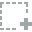
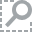
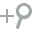
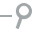
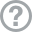
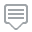
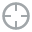
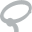
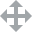
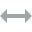
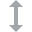
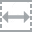
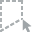
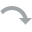
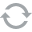
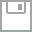
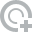
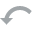
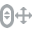
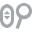
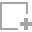
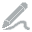
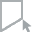
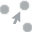
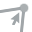

In [ ]:
plot(df)


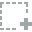
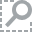
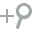
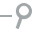
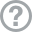
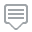
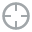
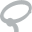
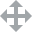
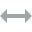
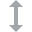
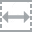
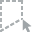
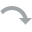
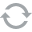
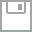
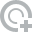
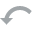
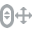
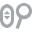
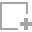
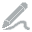
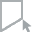
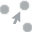
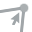

In [ ]:
plot(df, "Global_active_power")

In [ ]:
plot_correlation(df)

In [ ]:
plot_correlation(df, "Voltage", "Global_active_power")


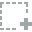
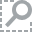
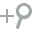
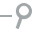
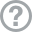
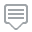
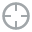
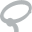
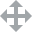
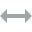
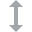
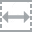
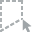
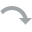
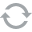
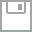
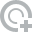
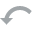
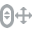
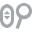
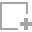
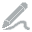
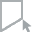
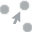
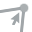

In [ ]:
plot_missing(df)


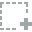
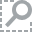
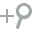
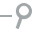
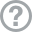
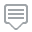
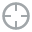
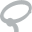
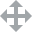
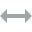
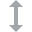
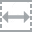
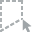
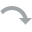
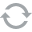
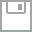
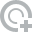
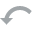
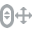
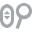
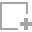
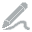
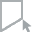
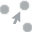
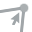

In [ ]:
plot_missing(df, "Voltage")

In [ ]:
create_report(df)

Computing index-size-chunk-size-agg-06454c1baadd7dcd5e26ed6a8a19cc4f:  48%|████▊     | 465/959 [00:09<00:07, 65.26it/s]      

In [ ]:
df.describe().transpose()

count        mean  ...      75%      max
Global_active_power    2049280.0    1.091615  ...    1.528   11.122
Global_reactive_power  2049280.0    0.123714  ...    0.194    1.390
Voltage                2049280.0  240.839858  ...  242.890  254.150
Global_intensity       2049280.0    4.627759  ...    6.400   48.400
Sub_metering_1         2049280.0    1.121923  ...    0.000   88.000
Sub_metering_2         2049280.0    1.298520  ...    1.000   80.000
Sub_metering_3         2049280.0    6.458447  ...   17.000   31.000

[7 rows x 8 columns]

In [ ]:
## finding all columns that have nan:

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
# filling nan with mean in any columns

for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

Data Visualization

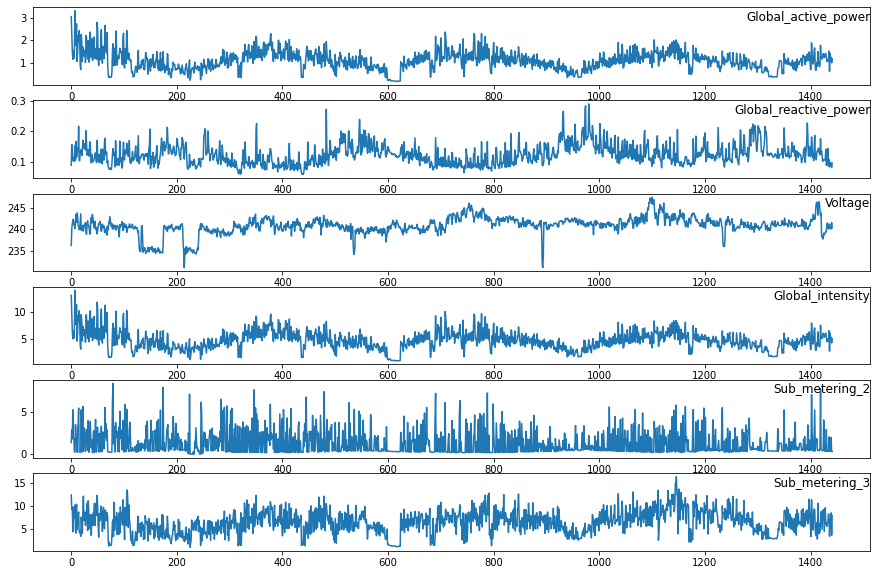

In [ ]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

In [ ]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [ ]:
variable = 'Global_active_power'

In [ ]:
df = df.Global_active_power.reset_index()

In [ ]:
print('shape: ', df.shape[0])
df.head()

shape:  2075259


dt  Global_active_power
0 2006-12-16 17:24:00                4.216
1 2006-12-16 17:25:00                5.360
2 2006-12-16 17:26:00                5.374
3 2006-12-16 17:27:00                5.388
4 2006-12-16 17:28:00                3.666

In [ ]:
df['Datetime'] = pd.to_datetime(df['dt'])

Text(0.5, 1.0, 'Time series of value by date time')

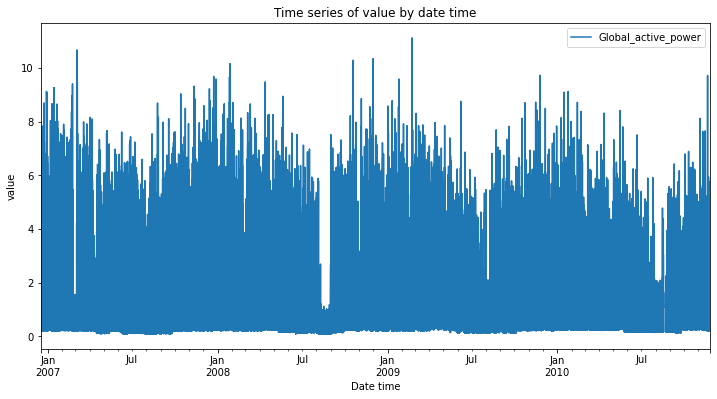

In [ ]:
df.plot(x='Datetime', y='Global_active_power', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('value')
plt.title('Time series of value by date time')

In [ ]:
df.head()

dt  Global_active_power            Datetime
0 2006-12-16 17:24:00                4.216 2006-12-16 17:24:00
1 2006-12-16 17:25:00                5.360 2006-12-16 17:25:00
2 2006-12-16 17:26:00                5.374 2006-12-16 17:26:00
3 2006-12-16 17:27:00                5.388 2006-12-16 17:27:00
4 2006-12-16 17:28:00                3.666 2006-12-16 17:28:00

In [ ]:
df.Global_active_power.describe()

count    2.075259e+06
mean     1.091615e+00
std      1.050655e+00
min      7.600000e-02
25%      3.100000e-01
50%      6.300000e-01
75%      1.520000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

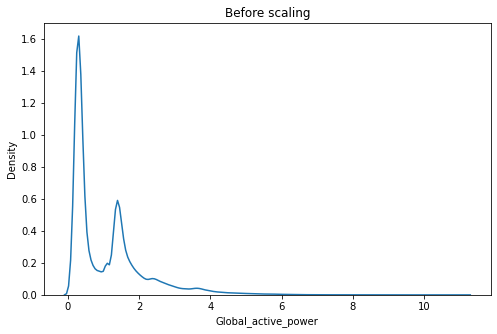

In [ ]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8,5))
ax1.set_title('Before scaling')
sns.kdeplot(df['Global_active_power'], ax=ax1)

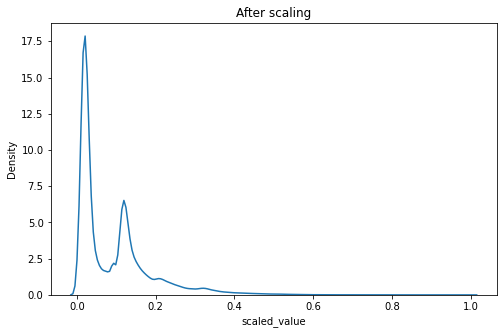

In [ ]:
#scale values (0,1)
scaler = MinMaxScaler(feature_range = (0,1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['Global_active_power'])), columns=['value'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(8,5))
ax1.set_title('After scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

In [ ]:
print('shape: ', df.shape[0])
df.head()

shape:  2075259


dt  Global_active_power            Datetime  scaled_value
0 2006-12-16 17:24:00                4.216 2006-12-16 17:24:00      0.374796
1 2006-12-16 17:25:00                5.360 2006-12-16 17:25:00      0.478363
2 2006-12-16 17:26:00                5.374 2006-12-16 17:26:00      0.479631
3 2006-12-16 17:27:00                5.388 2006-12-16 17:27:00      0.480898
4 2006-12-16 17:28:00                3.666 2006-12-16 17:28:00      0.325005

In [ ]:
######build LSTM model########
time_steps = 1440
metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1440, 32)          4352      
_________________________________________________________________
dense (Dense)                (None, 1440, 1)           33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
######split the sequence into a tumbling window of sub-sequences#########
sequence = np.array(df['scaled_value'])
time_steps= 1440 #(for 24hrs step with 1min timestamp)
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

In [ ]:
print(samples, subsequences)

2075259 1441


In [ ]:
sequence_trimmed.shape = (subsequences, time_steps, 1) #reshape for the lstm
print(sequence_trimmed.shape)

(1441, 1440, 1)


In [ ]:
import os
import datetime
import time

BATCH_SIZE = 32

def _getToday():
        return datetime.date.today().strftime("%Y%m%d")

#######output for model weights and loss###########
OUTPUT_PATH = '/content/drive/My Drive/Colab Notebooks/household_power_consumption'

#csv_logger_loss = "LSTM_model_loss_"+str(BATCH_SIZE)+"batch_size_"+time.ctime()+".csv"
csv_logger_loss = "LSTM_model_loss_"+str(BATCH_SIZE)+"batch_size_"+_getToday()+".csv"
weight_checkpoint = "LSTM_model_weights_"+str(BATCH_SIZE)+"batch_size_"+_getToday()+".hdf5"

csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, csv_logger_loss), append=True)
checkpoint= ModelCheckpoint(os.path.join(OUTPUT_PATH, weight_checkpoint), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Stop training when a monitored quantity has stopped improving.
early_stop = EarlyStopping(monitor="val_loss", patience = 15, mode = 'min', restore_best_weights=True)

In [ ]:
########train model########
%%time

training_dataset = sequence_trimmed
print('training_dataset: ', training_dataset.shape)

batch_size = 32
epochs= 100

model.fit(x=training_dataset, y=training_dataset,
			batch_size=batch_size, epochs=epochs,
			verbose=1, validation_data=(training_dataset, training_dataset),shuffle=False,
			callbacks=[TensorBoard(log_dir='../logs/{0}'), csv_logger,checkpoint,early_stop])



training_dataset:  (1441, 1440, 1)
Epoch 1/100
 1/46 [..............................] - ETA: 0s - loss: 0.3495 - mean_absolute_error: 0.3495WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
46/46 [==============================] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2172
Epoch 00001: val_loss improved from inf to 0.07273, saving model to /content/drive/My Drive/Colab Notebooks/household_power_consumption/LSTM_model_weights_32batch_size_20201129.hdf5
46/46 [==============================] - 5s 106ms/step - loss: 0.2172 - mean_absolute_error: 0.2172 - val_loss: 0.0727 - val_mean_absolute_error: 0.0727
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.0721 - mean_absolute_error: 0.0721
Epoch 00002: val_loss improved from 0.07273 to 

In [ ]:
Lstm_history_path = OUTPUT_PATH + '/' + csv_logger_loss
Lstm_history = pd.read_csv(Lstm_history_path, sep=',')
Lstm_history.tail()

epoch      loss  mean_absolute_error  val_loss  val_mean_absolute_error
145     95  0.005012             0.005012  0.003788                 0.003788
146     96  0.003895             0.003895  0.003693                 0.003693
147     97  0.003719             0.003719  0.003917                 0.003917
148     98  0.003940             0.003940  0.004865                 0.004865
149     99  0.004307             0.004307  0.004441                 0.004441

In [ ]:
def plot_train_history(history, title):
  """
    Plot loss function
  """
  fig = plt.figure(figsize=(10,5))
  plt.style.use('seaborn')
  
  loss = history['loss']
  val_loss = history['val_loss']
  
  epochs = range(len(loss))

  plt.plot(epochs, loss, 'c-', label='train')
  plt.plot(epochs, val_loss, 'm:', label='test')
  
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.title(title)
  plt.legend()
  plt.grid(True)
  
  #plt.savefig(os.path.join(OUTPUT_PATH, 'model_loss'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
  #plt.show()

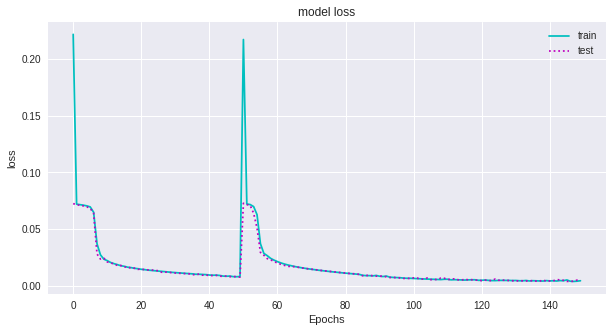

In [ ]:
plot_train_history(Lstm_history, 'model loss')

In [ ]:
#########Predict on the testing dataset###########

import math
from sklearn.metrics import mean_absolute_error

sequence = np.array(df['scaled_value'])
time_steps= 1440 #(for 24hrs step with 1min timestamp)
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)

2075259 1441


In [ ]:
sequence_trimmed.shape = (subsequences, time_steps, 1) #reshape for the lstm
print(sequence_trimmed.shape)

testing_dataset = sequence_trimmed
print('testing_dataset: ', testing_dataset.shape)

(1441, 1440, 1)
testing_dataset:  (1441, 1440, 1)


In [ ]:
testing_pred = model.predict(x=testing_dataset)
print('testing_pred: ', testing_pred.shape)

testing_pred:  (1441, 1440, 1)


In [ ]:
testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print('testing_dataset: ', testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print('testing_pred: ', testing_pred.shape)

testing_dataset:  (2075040, 1)
testing_pred:  (2075040, 1)


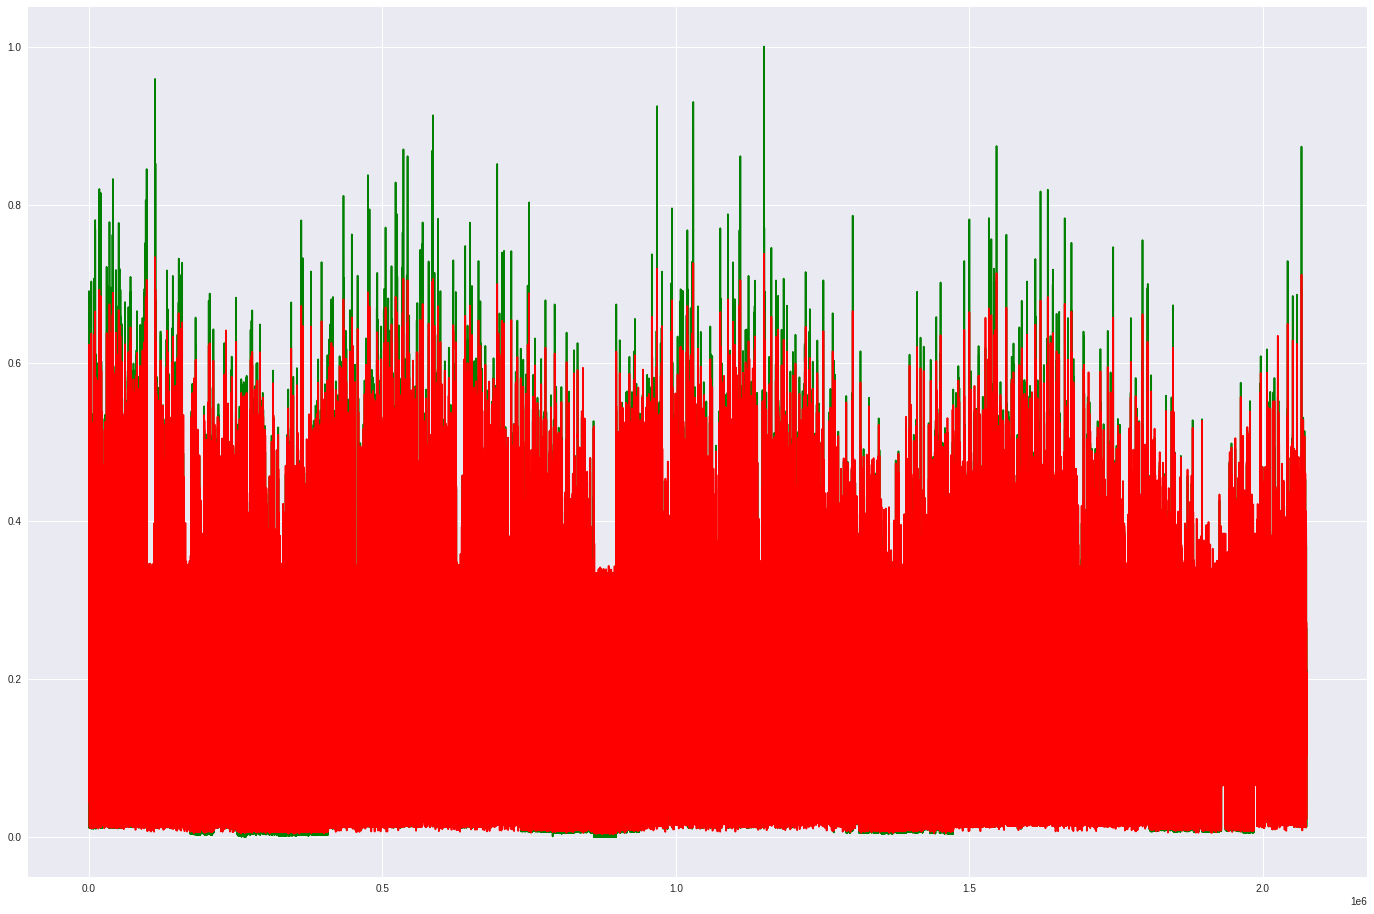

In [ ]:
#Plotting the testing and predicted datasets
plt.figure(figsize=(24,16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color='red')

In [ ]:
errorDF = testing_dataset - testing_pred

rmse = math.sqrt(mean_absolute_error(testing_dataset, testing_pred))
print('Test RMSE: %3f' % rmse)

Test RMSE: 0.066639


In [ ]:
#cutoff for errors and computing the threshold
dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores = dist.copy()
print('scores ',scores.shape)

scores.sort()
cutoff = int(0.999 * len(scores))
print('cutoff', cutoff)

threshold= scores[cutoff]
print('threshold',threshold)

scores  (2075040,)
cutoff 2072964
threshold 0.17393593956611303


In [ ]:
z = zip(dist >= threshold, dist)

In [ ]:
list(z)

[(False, 0.16127618624424556),
 (False, 0.11091155565974287),
 (False, 0.0835142867322981),
 (False, 0.036094923555127945),
 (False, 0.008122435659466909),
 (False, 0.00761512261833075),
 (False, 0.017962261373401456),
 (False, 0.012576194948505148),
 (False, 0.0056141520914944065),
 (False, 0.0028835977848383765),
 (False, 0.004194750510413792),
 (False, 0.0020725171936826214),
 (False, 0.00637121721171352),
 (False, 0.004203360257277355),
 (False, 0.006572777262723373),
 (False, 0.0017057341681471216),
 (False, 0.0024867106634444136),
 (False, 0.0025422314403498736),
 (False, 0.0038354207473066393),
 (False, 0.002326885681102231),
 (False, 0.0007195306195527662),
 (False, 0.06782011629208562),
 (False, 0.0429323797162926),
 (False, 0.00011323140126395792),
 (False, 0.011066027758627861),
 (False, 0.0009928276610939868),
 (False, 0.004040587823632258),
 (False, 0.002521895534552343),
 (False, 0.0022616316750713183),
 (False, 0.0019112760479329527),
 (False, 0.004635520976845525),
 (Fa

In [ ]:
#####classify a datapoint as anomaly or normal########
y_label = []
error = []

for idx, (is_anomaly, dist) in enumerate(z):
  if is_anomaly:
    y_label.append(1)
	
  else:
    y_label.append(0)
	
  error.append(dist)


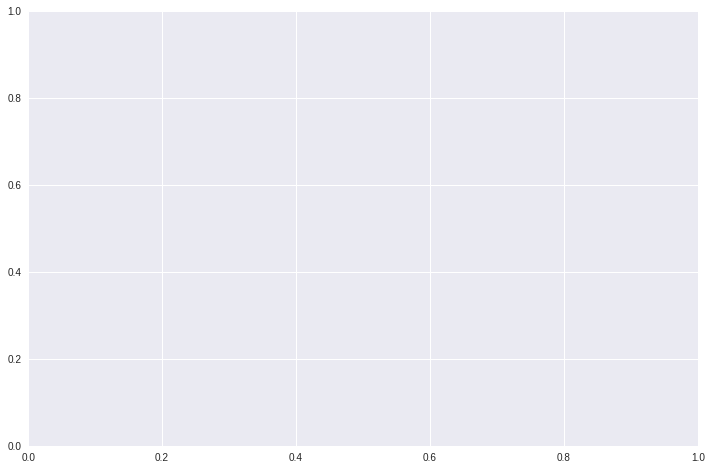

In [ ]:
#code to plot the data points with respect to the threshold.
viz= Visualization()
viz.draw_anomaly(y_label, error, threshold)

In [ ]:
#viz.draw_error(error, threshold)

In [ ]:
#Code to append the anomaly flag to the dataframe
adf = pd.DataFrame({'Datetime': df.loc[:len(y_label)-1,'Datetime'], 'Global_active_power': df.loc[:len(y_label)-1,'Global_active_power'],'error': error, 'anomaly': y_label})
adf

Empty DataFrame
Columns: [Datetime, Global_active_power, error, anomaly]
Index: []

NameError: ignored

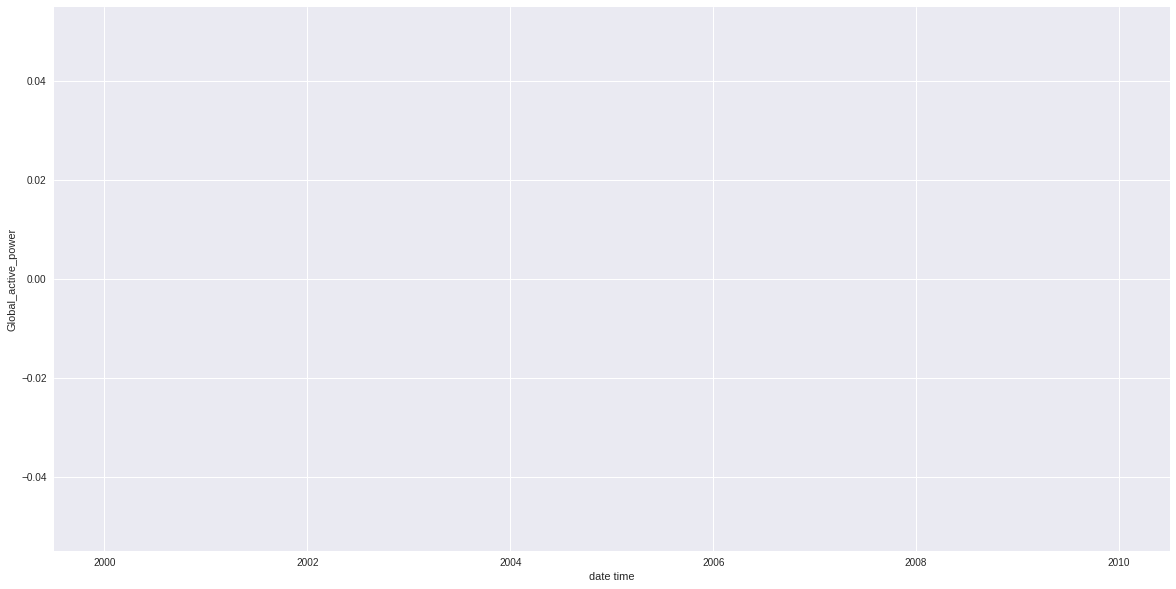

In [ ]:
#A graph showing anomalies
figure, axes = plt.subplots(figsize=(20,10))
axes.plot(adf['Datetime'].values, adf['Global_active_power'], color='g')
anomaliesDF = adf.query('anomaly== 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['Global_active_power'], color='r')
plt.xlabel('date time')
plt.ylabel('Global_active_power')
plt.title('Time Series of '+ observation+ ' by data time')

